<a href="https://colab.research.google.com/github/fuggu68/thesis-result/blob/main/model5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Important Library

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional
from keras.layers import LSTM
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Import Data

In [20]:
url='https://drive.google.com/file/d/1RoMg2LhpHn_PUmkwme7ZiD3bAYk22GXC/view?usp=sharing'
url2='https://drive.google.com/file/d/1FqOKFrOrgeM0Z2ygEPuohfTaOFjpOEeh/view?usp=sharing'

url='https://drive.google.com/uc?id=' + url.split('/')[-2]
url2='https://drive.google.com/uc?id=' + url2.split('/')[-2]

df = pd.read_csv(url2)

In [21]:
df.head(2)

,date,passenger
0,07/08/2017,2324
1,07/09/2017,2097


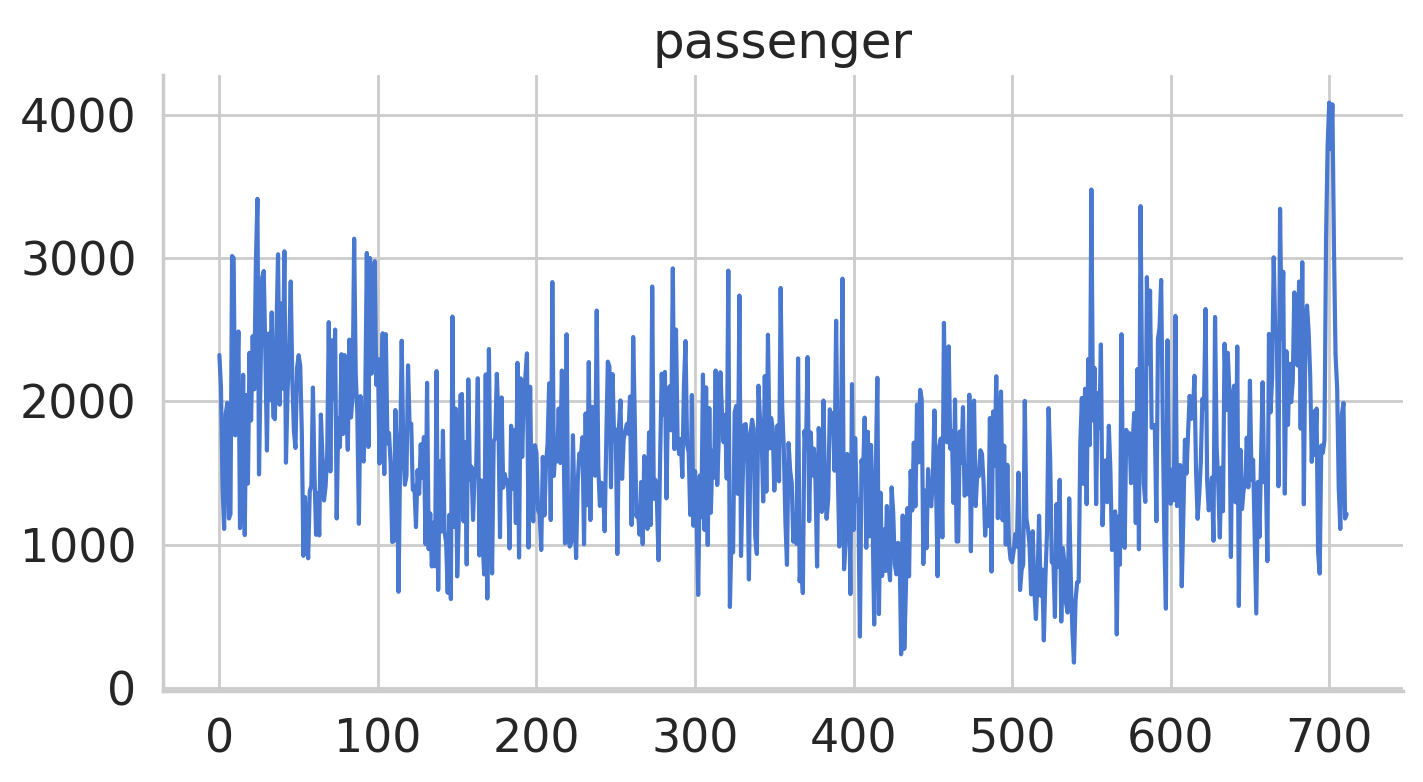

In [22]:
# @title passenger

from matplotlib import pyplot as plt
df['passenger'].plot(kind='line', figsize=(8, 4), title='passenger')
plt.gca().spines[['top', 'right']].set_visible(False)

# Formate Date

In [23]:
df['date']=pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [24]:
df.head(2)

,passenger
date,
2017-07-08,2324
2017-07-09,2097


# Visualize the data

<Axes: title={'center': 'line60'}, xlabel='date'>

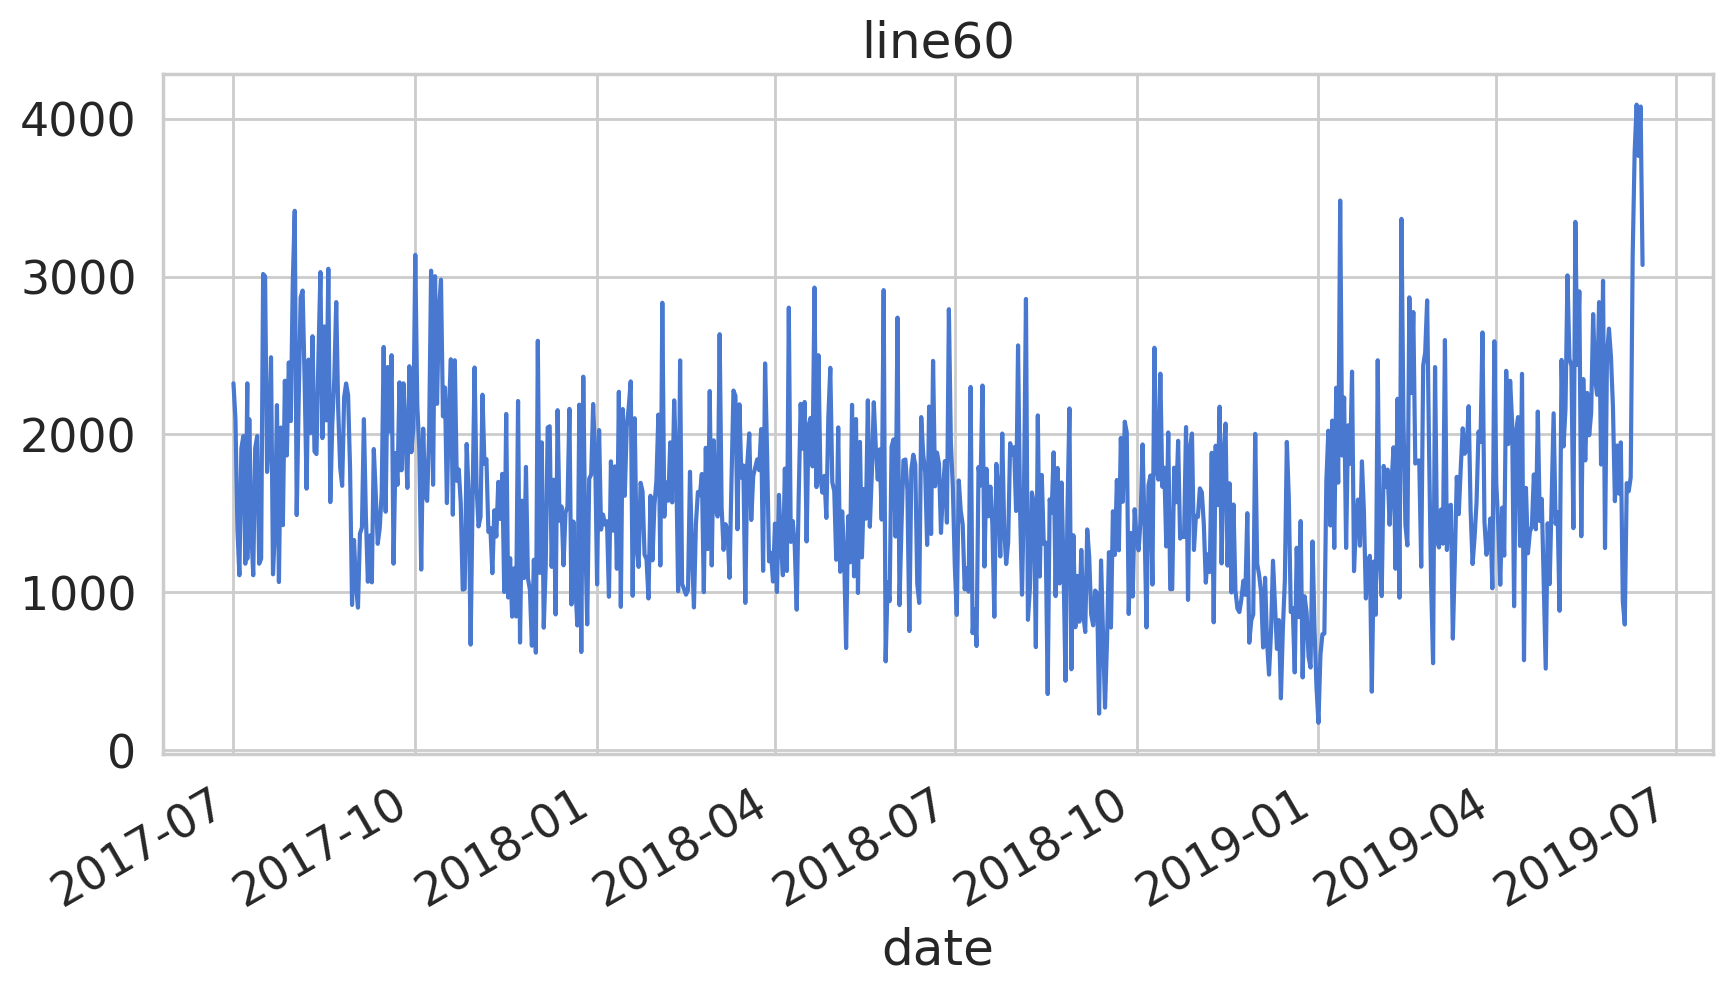

In [25]:
df['passenger'].plot(kind='line', figsize=(10, 5), title='line60')

# Normalization

In [26]:
# Normalize the passenger numbers
scaler = MinMaxScaler(feature_range=(0, 1))
df['passenger'] = scaler.fit_transform(df[['passenger']])



# Change to Supervised Model

In [27]:
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length - 1):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
sequence_length=10
# Recreate sequences with the corrected function
X, y = create_sequences(df['passenger'].values, sequence_length)

# Split the data into training and testing sets again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((560, 10), (141, 10), (560,), (141,))

# Model Architecture configurations (Model

In [28]:
# Define the LSTM model
from keras import optimizers
ADAM = optimizers.Adam(learning_rate=0.001)
model = Sequential()
model.add(keras.layers.Bidirectional(
    LSTM(units=128,
         input_shape=(X_train.shape[1], 1)))
)  # 128 neurons in the LSTM layer
model.add(keras.layers.Dropout(rate=0.2))
model.add(Dense(units=1))  # Output layer with a single neuron
model.compile(optimizer=ADAM, loss='mse', metrics=['mae'])  # Using Adam optimizer and MSE, MAE as metrics

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))



# Model Training

In [29]:
# Train the model
history = model.fit(X_train_reshaped,
                    y_train,
                    batch_size=1,
                    epochs=100,
                    validation_data=(X_test_reshaped, y_test),
                    verbose=1
                    )



Epoch 1/100
560/560 [==============================] - 12s 14ms/step - loss: 0.0236 - mae: 0.1216 - val_loss: 0.0196 - val_mae: 0.1099
Epoch 2/100
560/560 [==============================] - 6s 10ms/step - loss: 0.0223 - mae: 0.1182 - val_loss: 0.0192 - val_mae: 0.1113
Epoch 3/100
560/560 [==============================] - 7s 13ms/step - loss: 0.0213 - mae: 0.1158 - val_loss: 0.0180 - val_mae: 0.1070
Epoch 4/100
560/560 [==============================] - 7s 13ms/step - loss: 0.0210 - mae: 0.1160 - val_loss: 0.0198 - val_mae: 0.1126
Epoch 5/100
560/560 [==============================] - 6s 11ms/step - loss: 0.0209 - mae: 0.1156 - val_loss: 0.0201 - val_mae: 0.1141
Epoch 6/100
560/560 [==============================] - 7s 13ms/step - loss: 0.0213 - mae: 0.1171 - val_loss: 0.0188 - val_mae: 0.1102
Epoch 7/100
560/560 [==============================] - 6s 11ms/step - loss: 0.0208 - mae: 0.1155 - val_loss: 0.0182 - val_mae: 0.1078
Epoch 8/100
560/560 [==============================] - 7s 13m

In [30]:
# Evaluate the model on the test set
mse, mae = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f'MSE: {mse}, MAE: {mae}')

MSE: 0.021313708275556564, MAE: 0.11527828127145767


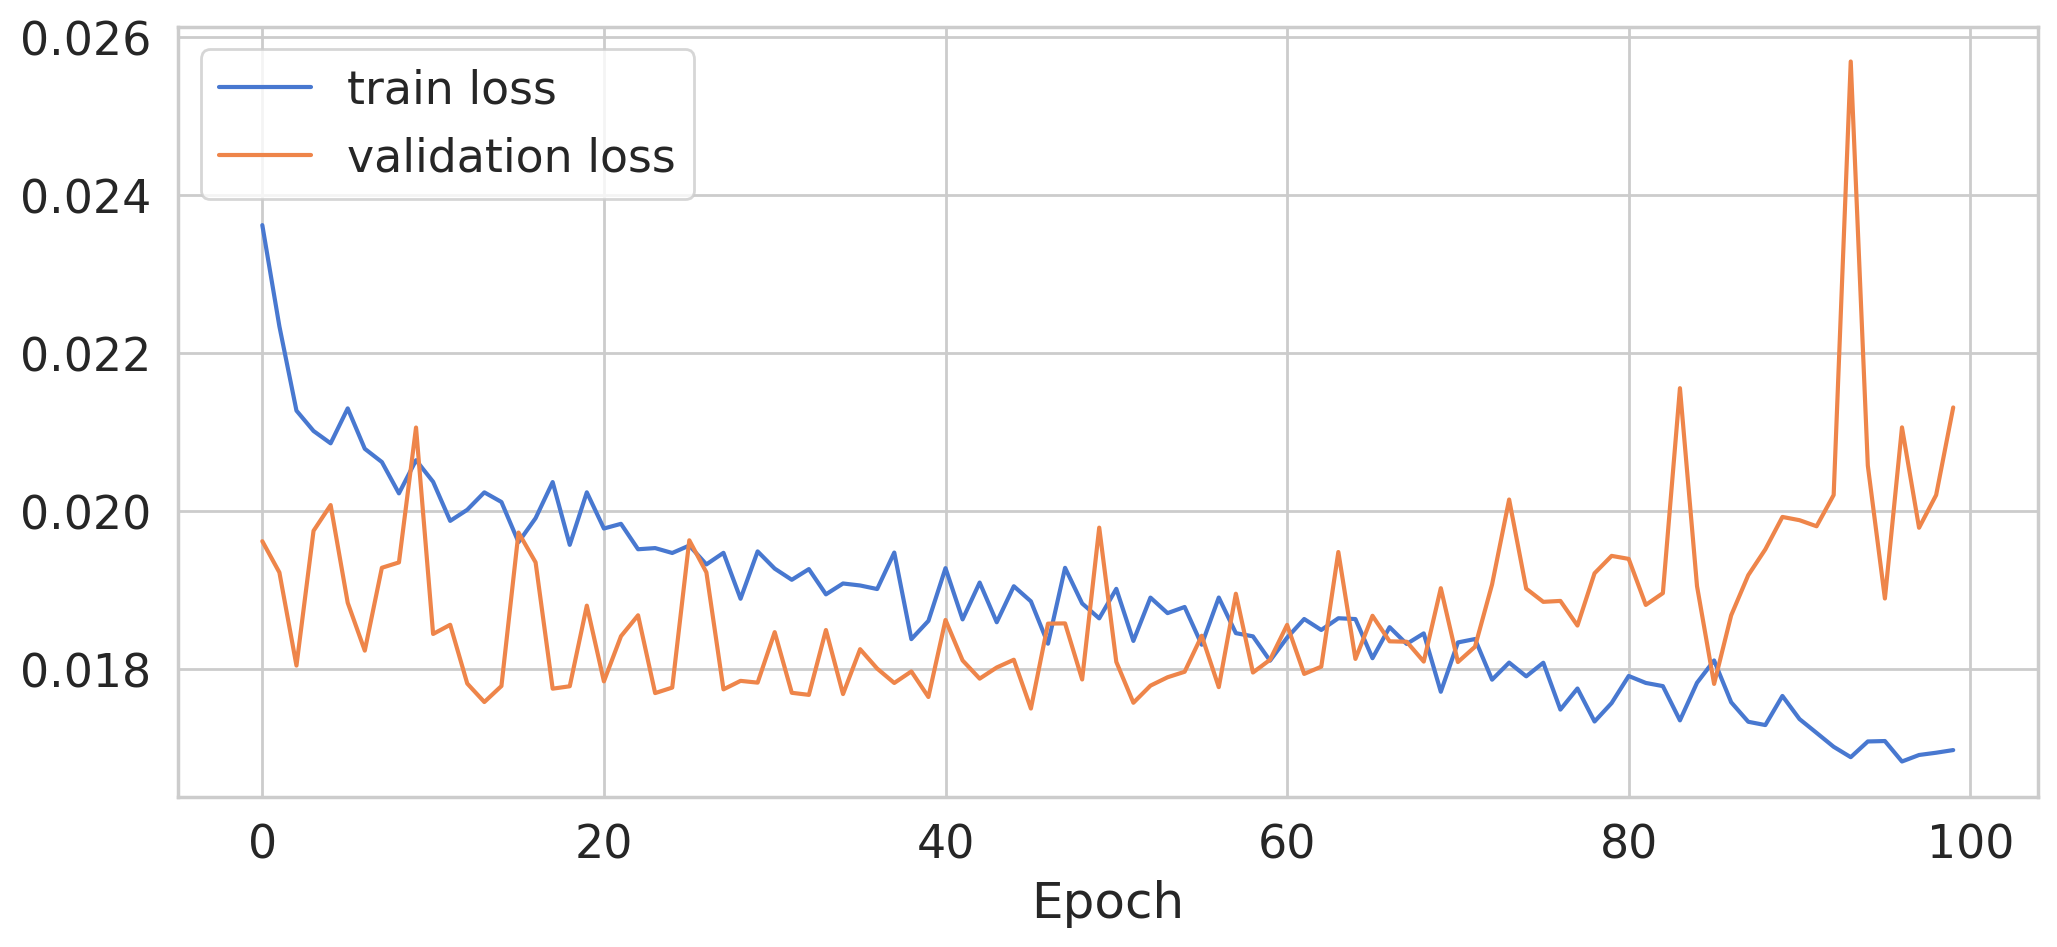

In [31]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.legend();

In [32]:
y_pred = model.predict(X_test)
x_pred = model.predict(X_train)

18/18 [==============================] - 0s 7ms/step


In [33]:
y_train_inv = scaler.inverse_transform(y_train.reshape(1, -1))

X_pred_inv = scaler.inverse_transform(x_pred.reshape(1, -1))

y_test_inv = scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = scaler.inverse_transform(y_pred)

In [34]:
mae = mean_absolute_error(y_test_inv[0], y_pred_inv[:,0])
print(f"Test MAE: {mae}")

Test MAE: 451.0839133837544


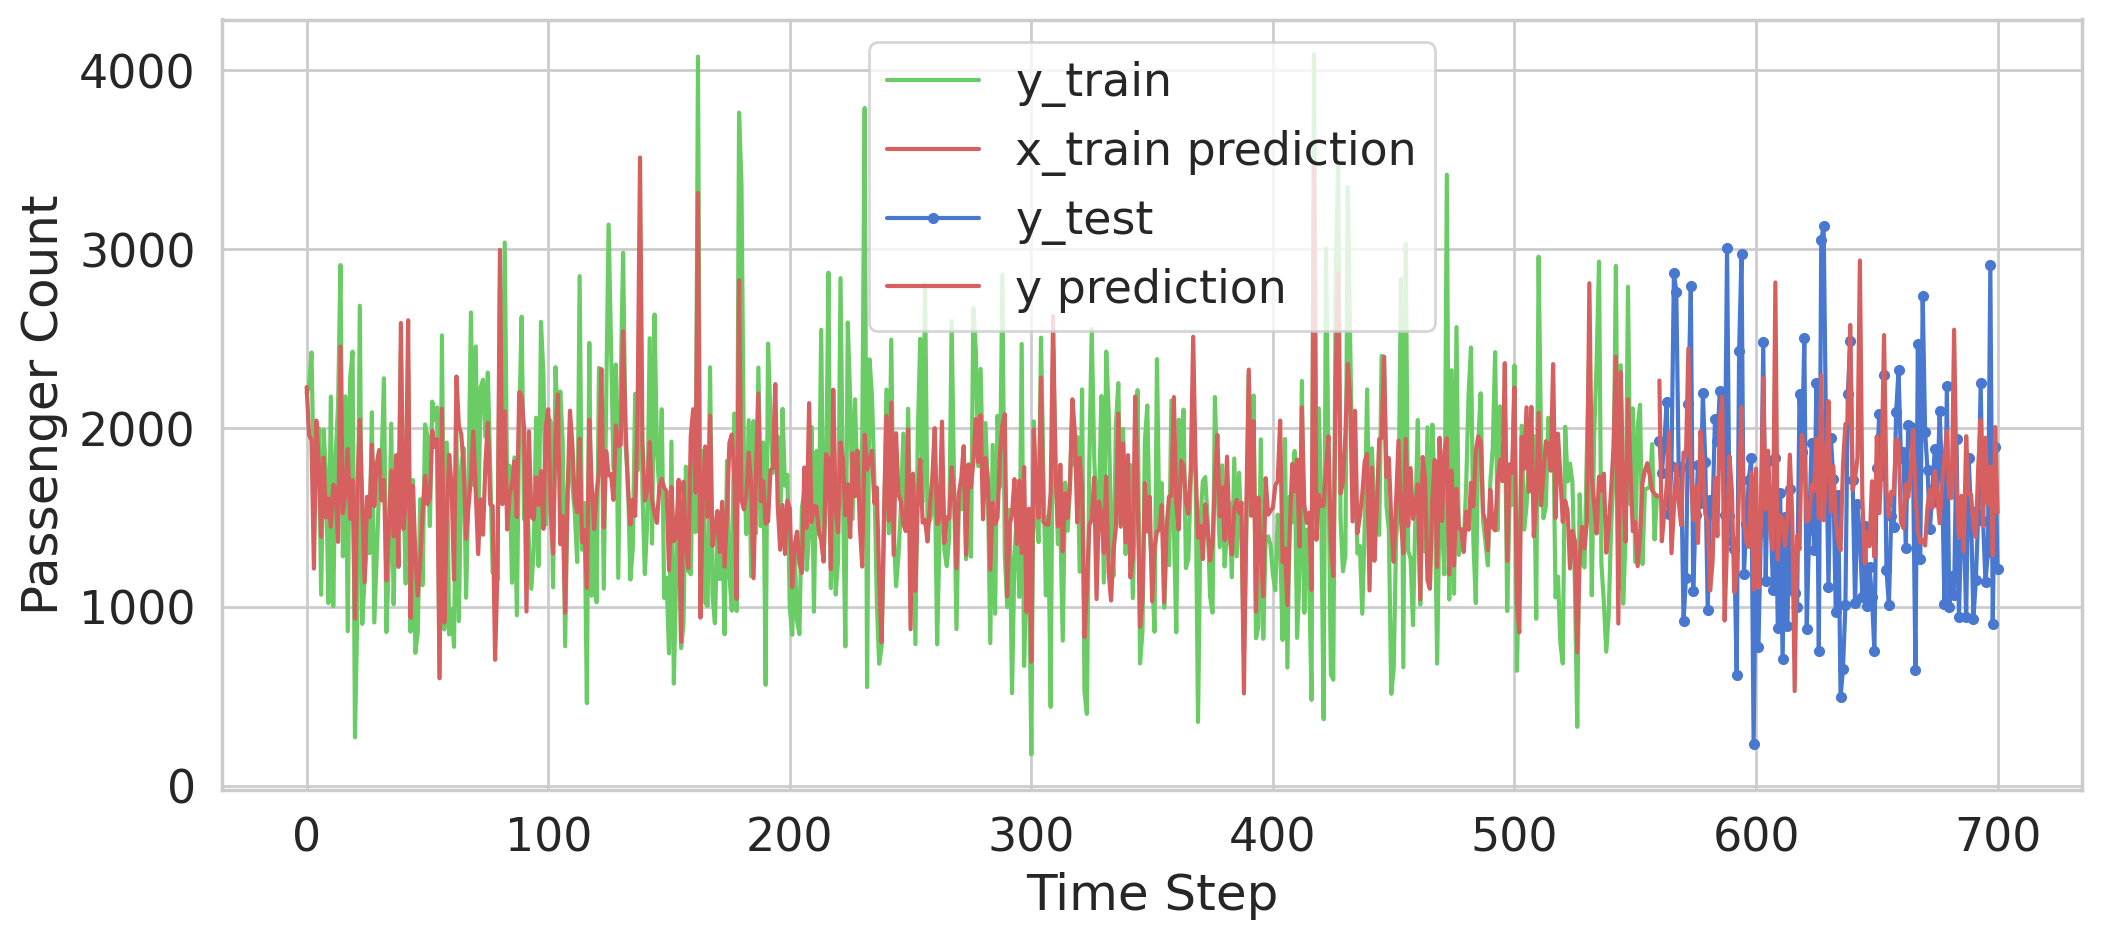

In [35]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(),'g', label="y_train")

plt.plot(np.arange(0, len(X_train)), X_pred_inv.flatten(), 'r', label="x_train prediction")

plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(),'b', marker='.', label="y_test")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="y prediction")

plt.ylabel('Passenger Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

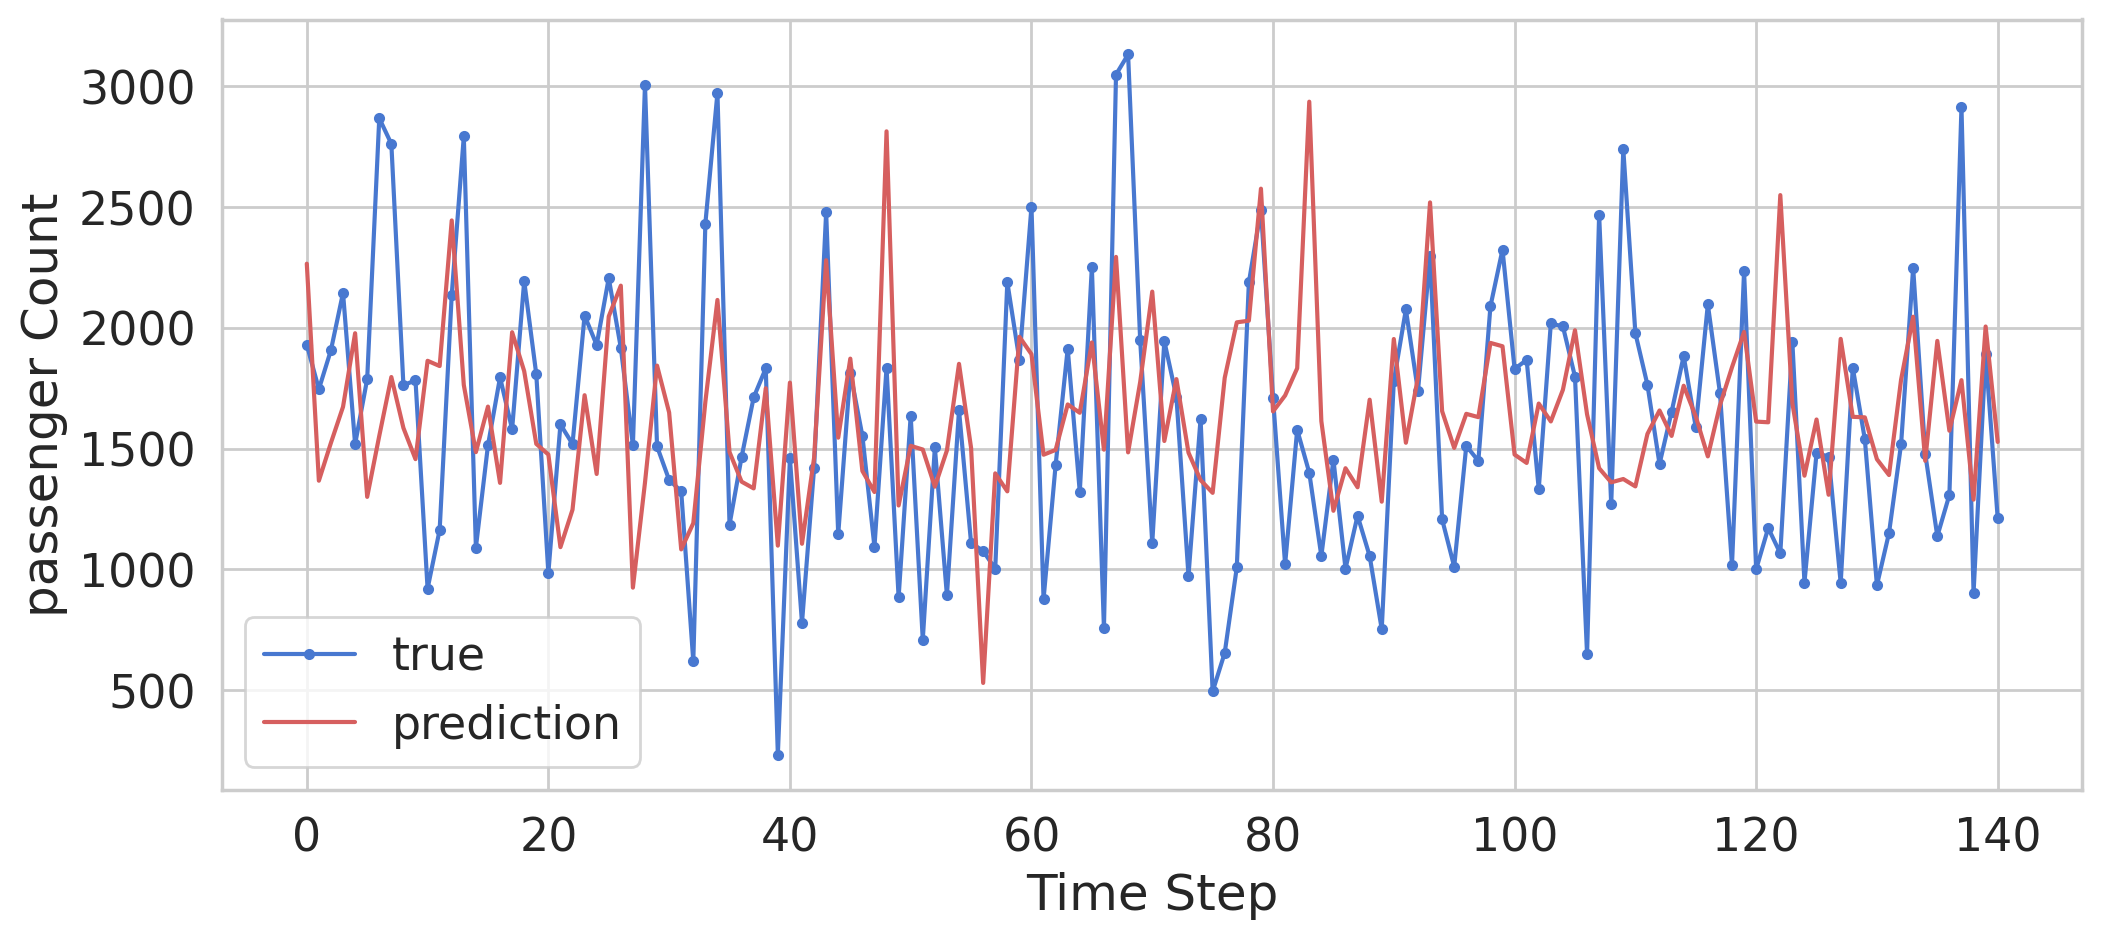

In [36]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('passenger Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();